In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import patsy
import re
%matplotlib inline

In [43]:
file_name = 'Seattle_Police_Department_911_Incident_Response.csv'
df = pd.read_csv(file_name, header=0, sep=',', low_memory=False)
df.rename(columns=lambda x : re.sub('\/|\s', '_', x), inplace=True)

In [44]:
df.shape

(1383463, 19)

In [53]:
data = df.dropna()
data.shape

(367019, 19)

In [5]:
data.head()

,CAD_CDW_ID,CAD_Event_Number,General_Offense_Number,Event_Clearance_Code,Event_Clearance_Description,Event_Clearance_SubGroup,Event_Clearance_Group,Event_Clearance_Date,Hundred_Block_Location,District_Sector,Zone_Beat,Census_Tract,Longitude,Latitude,Incident_Location,Initial_Type_Description,Initial_Type_Subgroup,Initial_Type_Group,At_Scene_Time
255,1658031,16000028114,201628114,161.0,TRESPASS,TRESPASS,TRESPASS,01/24/2016 11:59:45 AM,24XX BLOCK OF DEXTER AV N,D,D2,6000.1011,-122.34467,47.641580,"(47.64158, -122.34467)",NUISANCE - MISCHIEF,MISCELLANEOUS MISDEMEANORS,MISCELLANEOUS MISDEMEANORS,01/24/2016 10:46:45 AM
2146,1658050,16000028120,201628120,50.0,"BURGLARY - RESIDENTIAL, UNOCCUPIED",RESIDENTIAL BURGLARIES,BURGLARY,01/24/2016 12:01:15 PM,42XX BLOCK OF S FINDLAY ST,R,R3,10300.2005,-122.27943,47.551933,"(47.551933, -122.27943)",BURG - RES (INCL UNOCC STRUCTURES ON PROP),BURGLARY,RESIDENTIAL BURGLARIES,01/24/2016 10:55:44 AM
2375,1658053,16000028095,201628095,430.0,MOTOR VEHICLE COLLISION,TRAFFIC RELATED CALLS,MOTOR VEHICLE COLLISION INVESTIGATION,01/24/2016 12:06:53 PM,N 80 ST / GREENWOOD AV N,J,J2,2800.1003,-122.35530,47.686940,"(47.68694, -122.3553)",MOTOR VEHICLE COLLISION WITH INJURIES - PRIORI...,MOTOR VEHICLE COLLISION INVESTIGATION,TRAFFIC RELATED CALLS,01/24/2016 10:17:27 AM
2432,1658054,16000028092,201628092,50.0,"BURGLARY - RESIDENTIAL, UNOCCUPIED",RESIDENTIAL BURGLARIES,BURGLARY,01/24/2016 12:03:53 PM,1XX BLOCK OF NW 60 ST,B,B2,3400.3000,-122.35810,47.672348,"(47.672348, -122.3581)",BURG - RES (INCL UNOCC STRUCTURES ON PROP),BURGLARY,RESIDENTIAL BURGLARIES,01/24/2016 10:29:37 AM
2443,1658055,16000028044,201628044,430.0,MOTOR VEHICLE COLLISION,TRAFFIC RELATED CALLS,MOTOR VEHICLE COLLISION INVESTIGATION,01/24/2016 12:10:26 PM,15 AV / E OLIVE ST,C,C1,7900.5006,-122.31276,47.616447,"(47.616447, -122.31276)",DUI - DRIVING UNDER INFLUENCE,TRAFFIC RELATED CALLS,TRAFFIC RELATED CALLS,01/24/2016 08:58:44 AM


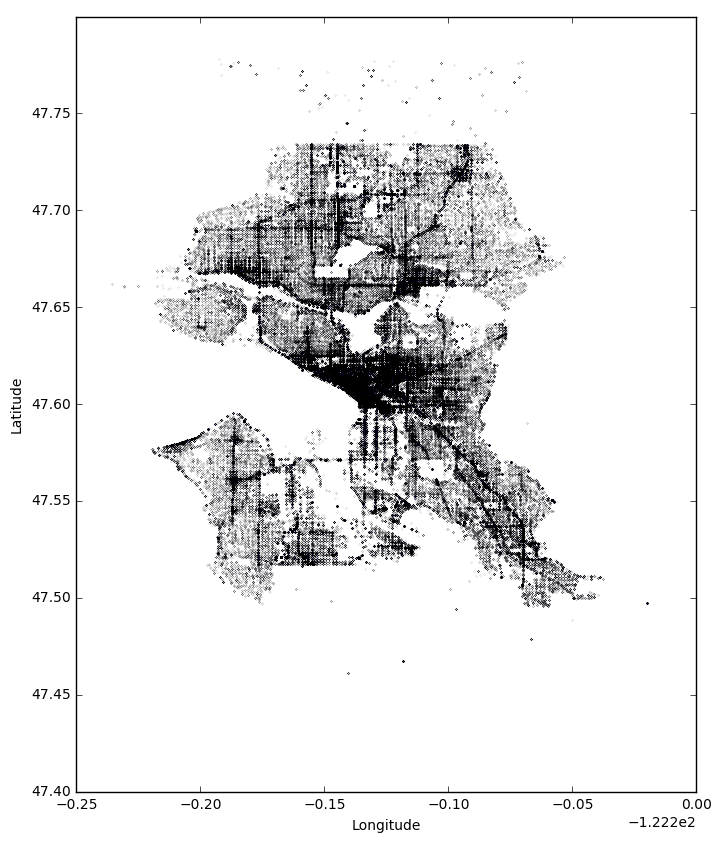

In [6]:
# Histogram
data.plot(x = 'Longitude', y = 'Latitude', kind = 'scatter', figsize = (8, 10), s = 0.005);

In [7]:
xs = np.array(data[[12]])
ys = np.array(data[[13]])

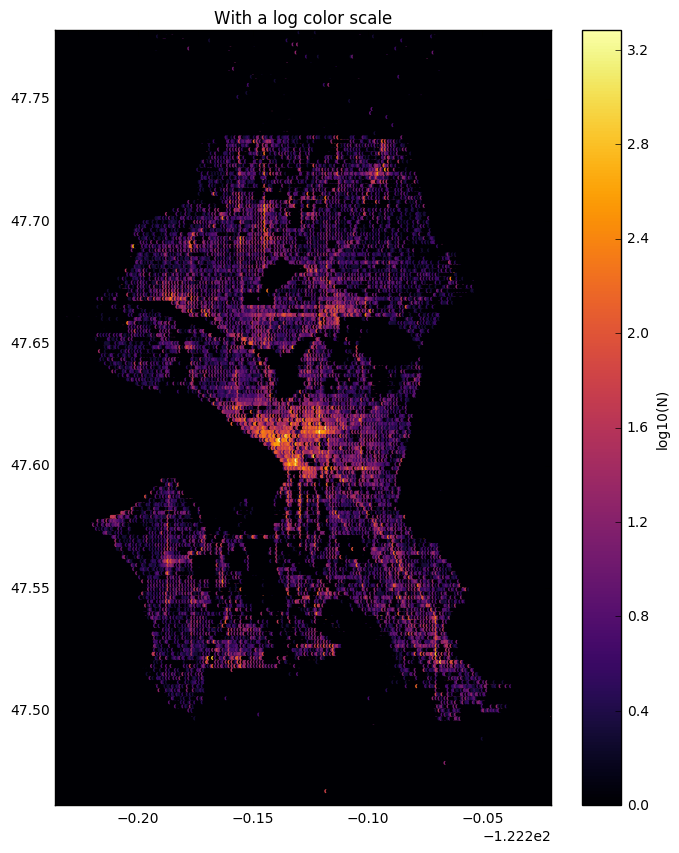

In [8]:
xmin = xs.min()
xmax = xs.max()
ymin = ys.min()
ymax = ys.max()

fig, ax = plt.subplots(figsize=(8, 10))

hb = ax.hexbin(xs, ys, gridsize=333, bins='log', cmap='inferno')
# hb = ax.hexbin(xs, ys, gridsize=300, bins='log', cmap='gnuplot')
ax.axis([xmin, xmax, ymin, ymax])
ax.set_title("With a log color scale")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')

In [9]:
# plot the frequency of incidents in a day
at_scene_time = data['At_Scene_Time']

# convert the datetime to 24 hour format
at_scene_time = pd.to_datetime(at_scene_time, format='%m/%d/%Y %I:%M:%S %p')
at_scene_time_hourly = at_scene_time.dt.strftime('%H')
at_scene_time_hourly = pd.to_numeric(at_scene_time_hourly)

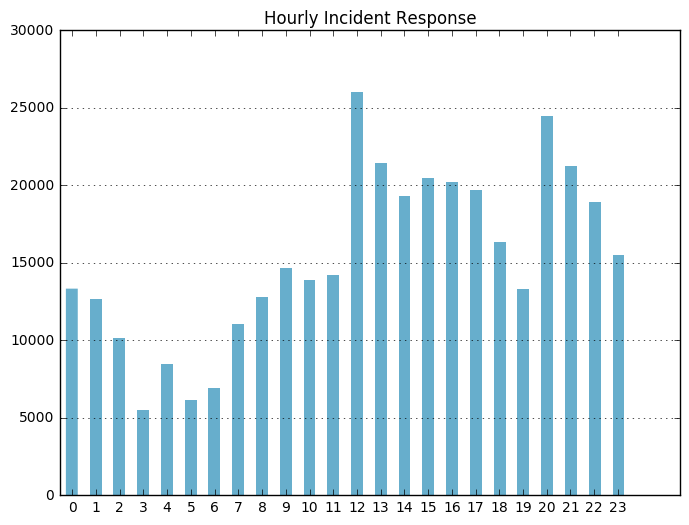

In [10]:
fig, ax = plt.subplots(figsize = (8, 6))
ax.hist(x = at_scene_time_hourly, bins=24, color='#67aecc', edgecolor='none',rwidth = 0.5, range = (0, 23))
ax.set_xticks(np.linspace(0.5,22.5,24)) 
ax.set_xticklabels(tuple(x for x in range(24))) 
ax.set_title("Hourly Incident Response")
ax.grid(axis = 'y')

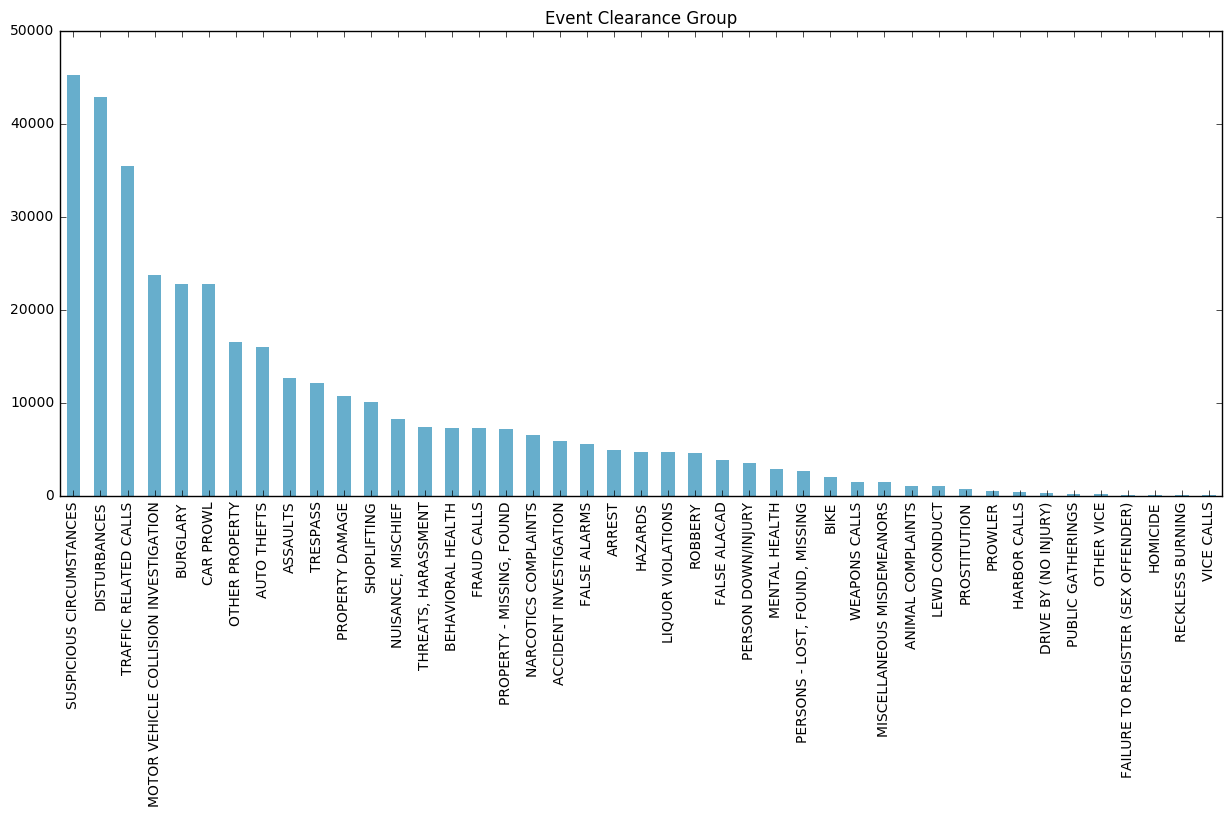

In [11]:
# Event Clearance Group count
data['Event_Clearance_Group'].value_counts().plot(kind="bar", figsize=(15, 6), 
                                                  color='#67aecc', edgecolor='none',
                                                 title='Event Clearance Group');

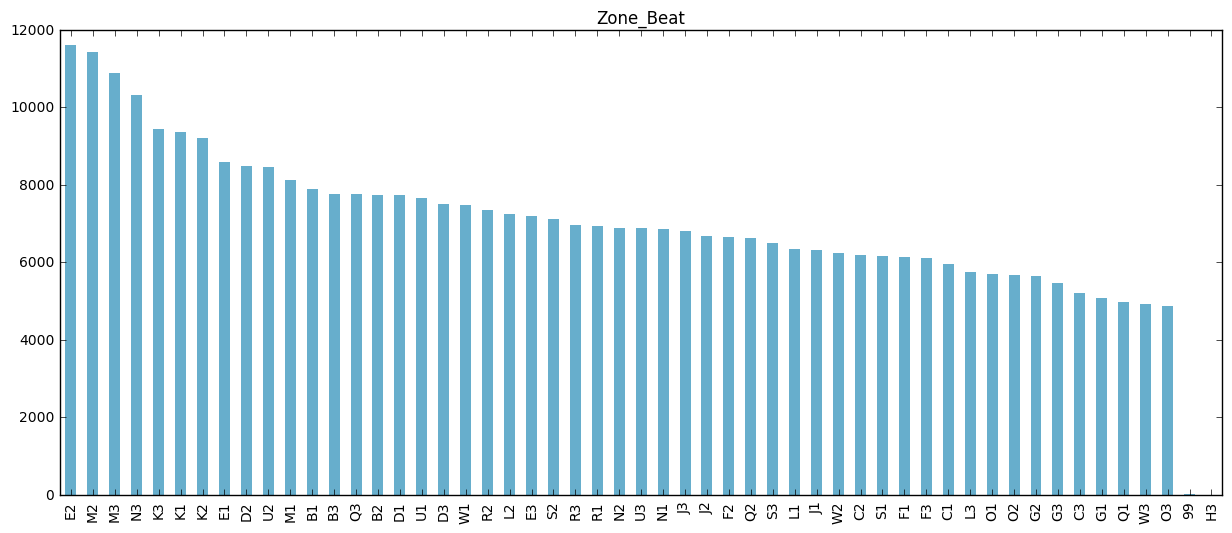

In [12]:
data['Zone_Beat'].value_counts().plot(kind = "bar", figsize= (15, 6), 
                                      color = '#67aecc', edgecolor='none',
                                     title='Zone_Beat');

### Association Rules

In [15]:
from FPgrowth import fpgrowth
from FPgrowth import generate_rules

In [16]:
association = data[[6,9]]
hour = at_scene_time_hourly = at_scene_time.dt.strftime('%H')
association['At_Scene_Time_Hour'] = hour
association = np.array(association)

In [17]:
# Generate all the frequent itemsets using the FP-growth algorithm.
F, support_data = fpgrowth(association, min_support=0.006, verbose=True)

{SUSPICIOUS CIRCUMSTANCES}:  sup = 0.123
{02}:  sup = 0.028
{DISTURBANCES, 02}:  sup = 0.007
{L}:  sup = 0.053
{SUSPICIOUS CIRCUMSTANCES, L}:  sup = 0.007
{00}:  sup = 0.036
{DISTURBANCES, 00}:  sup = 0.007
{MOTOR VEHICLE COLLISION INVESTIGATION}:  sup = 0.065
{21}:  sup = 0.058
{SUSPICIOUS CIRCUMSTANCES, 21}:  sup = 0.008
{DISTURBANCES, 21}:  sup = 0.008
{TRAFFIC RELATED CALLS, 21}:  sup = 0.007
{R}:  sup = 0.058
{TRAFFIC RELATED CALLS, R}:  sup = 0.007
{SUSPICIOUS CIRCUMSTANCES, R}:  sup = 0.009
{G}:  sup = 0.044
{S}:  sup = 0.054
{SUSPICIOUS CIRCUMSTANCES, S}:  sup = 0.008
{TRAFFIC RELATED CALLS, S}:  sup = 0.007
{MENTAL HEALTH}:  sup = 0.008
{17}:  sup = 0.054
{D}:  sup = 0.065
{SUSPICIOUS CIRCUMSTANCES, D}:  sup = 0.006
{DISTURBANCES, D}:  sup = 0.008
{20}:  sup = 0.067
{SUSPICIOUS CIRCUMSTANCES, 20}:  sup = 0.009
{DISTURBANCES, 20}:  sup = 0.008
{09}:  sup = 0.04
{O}:  sup = 0.044
{TRAFFIC RELATED CALLS, O}:  sup = 0.007
{W}:  sup = 0.051
{SUSPICIOUS CIRCUMSTANCES, W}:  sup = 0.0

In [18]:
# Generate the association rules from a list of frequent itemsets.
H = generate_rules(F, support_data, min_confidence=0.2, verbose=True)

{02} ---> {DISTURBANCES}:  conf = 0.239, sup = 0.007
{00} ---> {DISTURBANCES}:  conf = 0.206, sup = 0.007
{01} ---> {DISTURBANCES}:  conf = 0.226, sup = 0.008


### Classification

In [54]:
shoplifting = data[data.Event_Clearance_Group == 'SHOPLIFTING']
burglary = data[data.Event_Clearance_Group == 'BURGLARY']
print(shoplifting.shape)
print(burglary.shape)

(10043, 19)
(22774, 19)


In [55]:
clf_data = data.ix[data.Event_Clearance_Group.isin(['BURGLARY', 'SHOPLIFTING'])]

In [69]:
binary_data = patsy.dmatrix("District_Sector", clf_data, return_type='dataframe')
del binary_data['Intercept']
binary_data.rename(columns=lambda x : x.replace('District_Sector[T.', ''), inplace=True)
binary_data.rename(columns=lambda x : x.replace(']', ''), inplace=True)

In [76]:
at_scene_time = clf_data['At_Scene_Time']

# convert the datetime to 24 hour format
at_scene_time = pd.to_datetime(at_scene_time, format='%m/%d/%Y %I:%M:%S %p')
at_scene_time = pd.DatetimeIndex(at_scene_time)
at_scene_time_24 = at_scene_time.hour
binary_data['at_scene_time'] = at_scene_time_24

In [80]:
X = binary_data.values
y = clf_data['Event_Clearance_Group'].values

In [81]:
# split the data into training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [84]:
# resample the imbalanced training data
from imblearn.over_sampling import SMOTE
sm = SMOTE(kind='regular')
X_resampled_train, y_resampled_train = sm.fit_sample(X, y)

In [87]:
import copy
import operator
import sys, math, random

from sklearn.base import ClassifierMixin
from sklearn.tree import DecisionTreeClassifier

class LogitBoostClassifier(ClassifierMixin):
    """A LogitBoost classifier.

    A LogitBoost [1] classifier is a meta-estimator that begins by fitting a
    classifier on the original dataset and then fits additional copies of the
    classifier on the same dataset but where the weights of incorrectly
    classified instances are adjusted such that subsequent classifiers focus
    more on difficult cases.

    Parameters
    ----------
    base_estimator : object, optional (default=DecisionTreeClassifier)
        The base estimator from which the boosted ensemble is built.
        Support for sample weighting is required, as well as proper `classes_`
        and `n_classes_` attributes.

    n_estimators : integer, optional (default=50)
        The maximum number of estimators at which boosting is terminated.
        In case of perfect fit, the learning procedure is stopped early.

    learning_rate : float, optional (default=1.)
        Learning rate shrinks the contribution of each classifier by
        ``learning_rate``. There is a trade-off between ``learning_rate`` and
        ``n_estimators``.

    algorithm : {'SAMME', 'SAMME.R'}, optional (default='SAMME.R')
        If 'SAMME.R' then use the SAMME.R real boosting algorithm.
        ``base_estimator`` must support calculation of class probabilities.
        If 'SAMME' then use the SAMME discrete boosting algorithm.
        The SAMME.R algorithm typically converges faster than SAMME,
        achieving a lower test error with fewer boosting iterations.

    random_state : int, RandomState instance or None, optional (default=None)
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`.

    Attributes
    ----------
    `estimators_` : list of classifiers
        The collection of fitted sub-estimators.

    `classes_` : array of shape = [n_classes]
        The classes labels.

    `n_classes_` : int
        The number of classes.

    `estimator_weights_` : array of floats
        Weights for each estimator in the boosted ensemble.

    `estimator_errors_` : array of floats
        Classification error for each estimator in the boosted
        ensemble.

    `feature_importances_` : array of shape = [n_features]
        The feature importances if supported by the ``base_estimator``.

    References
    ----------
    .. [1] J. Friedman, T. Hastie, R. Tibshirani, "Additive Logistic Regression: 
           A Statistical View of Boosting", 2000.

    """
    def __init__(self,
                 base_estimator=DecisionTreeClassifier(max_depth=1),
                 n_estimators=50,
                 estimator_params=tuple(),
                 learning_rate=1.,
                 algorithm='SAMME.R'):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.estimator_params = estimator_params
        self.learning_rate = learning_rate
        self.algorithm = algorithm

    def _make_estimator(self, append=True):
        """Make and configure a copy of the `base_estimator_` attribute.

        Warning: This method should be used to properly instantiate new
        sub-estimators.
        """
        estimator = copy.deepcopy(self.base_estimator)
        estimator.set_params(**dict((p, getattr(self, p))
                                    for p in self.estimator_params))

        if append:
            self.estimators_.append(estimator)

        return estimator

    def fit(self, X, y, sample_weight=None):
        # Check parameters.
        if self.learning_rate <= 0:
            raise ValueError("learning_rate must be greater than zero.")

        if sample_weight is None:
            # Initialize weights to 1 / n_samples.
            sample_weight = np.empty(X.shape[0], dtype=np.float)
            sample_weight[:] = 1. / X.shape[0]
        else:
            # Normalize existing weights.
            sample_weight = sample_weight / sample_weight.sum(dtype=np.float64)

        # Check that the sample weights sum is positive.
        if sample_weight.sum() <= 0:
            raise ValueError(
                "Attempting to fit with a non-positive "
                "weighted number of samples.")

        # Clear any previous fit results.
        self.estimators_ = []
        self.estimator_weights_ = np.zeros(self.n_estimators, dtype=np.float)
        self.estimator_errors_ = np.ones(self.n_estimators, dtype=np.float)

        for iboost in range(self.n_estimators):
            #print 'Iteration [%s]' % (iboost)

            # Fit the estimator.
            estimator = self._make_estimator()
            estimator.fit(X, y, sample_weight=sample_weight)

            if iboost == 0:
                self.classes_ = getattr(estimator, 'classes_', None)
                self.n_classes_ = len(self.classes_)

            # Generate estimator predictions.
            y_pred = estimator.predict(X)

            # Instances incorrectly classified.
            incorrect = y_pred != y

            # Error fraction.
            estimator_error = np.mean(
                np.average(incorrect, weights=sample_weight, axis=0))

            # Boost weight using multi-class AdaBoost SAMME alg.
            estimator_weight = self.learning_rate * (
                np.log((1. - estimator_error) / estimator_error) +
                np.log(self.n_classes_ - 1.))

            # Only boost the weights if there is another iteration of fitting.
            if not iboost == self.n_estimators - 1:
                # Only boost positive weights (logistic loss).
                sample_weight *= np.log(1 + np.exp(estimator_weight * incorrect *
                                        ((sample_weight > 0) |
                                         (estimator_weight < 0))))

            self.estimator_weights_[iboost] = estimator_weight
            self.estimator_errors_[iboost] = estimator_error

    def _check_fitted(self):
        if not hasattr(self, "estimators_"):
            raise ValueError("Call 'fit' first.")

    def predict(self, X):
        X = numpy.array(X)
        N, d = X.shape
        pred = numpy.zeros(N)
        for estimator, w in zip(self.estimators_, self.estimator_weights_):
            pred += estimator.predict(X) * w
        pred /= self.estimator_weights_.sum()

        return pred

    def decision_function(self, X):
        """Compute the decision function of ``X``.

        Parameters
        ----------
        X : array-like of shape = [n_samples, n_features]
            The input samples.

        Returns
        -------
        score : array, shape = [n_samples, k]
            The decision function of the input samples. The order of
            outputs is the same of that of the `classes_` attribute.
            Binary classification is a special cases with ``k == 1``,
            otherwise ``k==n_classes``. For binary classification,
            values closer to -1 or 1 mean more like the first or second
            class in ``classes_``, respectively.
        """
        self._check_fitted()
        X = np.asarray(X)

        n_classes = self.n_classes_
        classes = self.classes_[:, np.newaxis]
        pred = None

        if self.algorithm == 'SAMME.R':
            # The weights are all 1. for SAMME.R
            pred = sum(_samme_proba(estimator, n_classes, X)
                       for estimator in self.estimators_)
        else:   # self.algorithm == "SAMME"
            pred = sum((estimator.predict(X) == classes).T * w
                       for estimator, w in zip(self.estimators_,
                                               self.estimator_weights_))

        pred /= self.estimator_weights_.sum()
        if n_classes == 2:
            pred[:, 0] *= -1
            return pred.sum(axis=1)
        return pred

    def predict(self, X):
        """Predict classes for X.

        The predicted class of an input sample is computed as the weighted mean
        prediction of the classifiers in the ensemble.

        Parameters
        ----------
        X : array-like of shape = [n_samples, n_features]
            The input samples.

        Returns
        -------
        y : array of shape = [n_samples]
            The predicted classes.
        """
        pred = self.decision_function(X)

        if self.n_classes_ == 2:
            return self.classes_.take(pred > 0, axis=0)

        return self.classes_.take(np.argmax(pred, axis=1), axis=0)

    def predict_proba(self, X):
        """Predict class probabilities for X.

        The predicted class probabilities of an input sample is computed as
        the weighted mean predicted class probabilities of the classifiers
        in the ensemble.

        Parameters
        ----------
        X : array-like of shape = [n_samples, n_features]
            The input samples.

        Returns
        -------
        p : array of shape = [n_samples]
            The class probabilities of the input samples. The order of
            outputs is the same of that of the `classes_` attribute.
        """
        X = np.asarray(X)
        n_classes = self.n_classes_

        if self.algorithm == 'SAMME.R':
            # The weights are all 1. for SAMME.R
            proba = sum(_samme_proba(estimator, n_classes, X)
                        for estimator in self.estimators_)
        else:   # self.algorithm == "SAMME"
            proba = sum(estimator.predict_proba(X) * w
                        for estimator, w in zip(self.estimators_,
                                                self.estimator_weights_))

        proba /= self.estimator_weights_.sum()
        proba = np.log(1 + np.exp((1. / (n_classes - 1)) * proba))
        normalizer = proba.sum(axis=1)[:, np.newaxis]
        normalizer[normalizer == 0.0] = 1.0
        proba /= normalizer

        return proba

def _samme_proba(estimator, n_classes, X):
    """Calculate algorithm 4, step 2, equation c) of Zhu et al [1].

    References
    ----------
    .. [1] J. Zhu, H. Zou, S. Rosset, T. Hastie, "Multi-class AdaBoost", 2009.

    """
    proba = estimator.predict_proba(X)

    # Displace zero probabilities so the log is defined.
    # Also fix negative elements which may occur with
    # negative sample weights.
    proba[proba <= 0] = 1e-5
    log_proba = np.log(proba)

    return (n_classes - 1) * (log_proba - (1. / n_classes)
                           * log_proba.sum(axis=1)[:, np.newaxis])

In [90]:
# Performing classifiers on the training data
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import logitboostclassifier

tree_clf = DecisionTreeClassifier(max_leaf_nodes=10)
tree_clf.fit(X_resampled_train, y_resampled_train)

ab_clf = AdaBoostClassifier(n_estimators=100)
ab_clf.fit(X_resampled_train, y_resampled_train)

lb_clf = LogitBoostClassifier(n_estimators=100)
lb_clf.fit(X_resampled_train, y_resampled_train)

extra_clf = ExtraTreesClassifier(n_estimators=10, max_depth=None, random_state=0)
extra_clf.fit(X_resampled_train, y_resampled_train)

random_clf = RandomForestClassifier(n_estimators=10, max_depth=None, random_state=0)
random_clf.fit(X_resampled_train, y_resampled_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

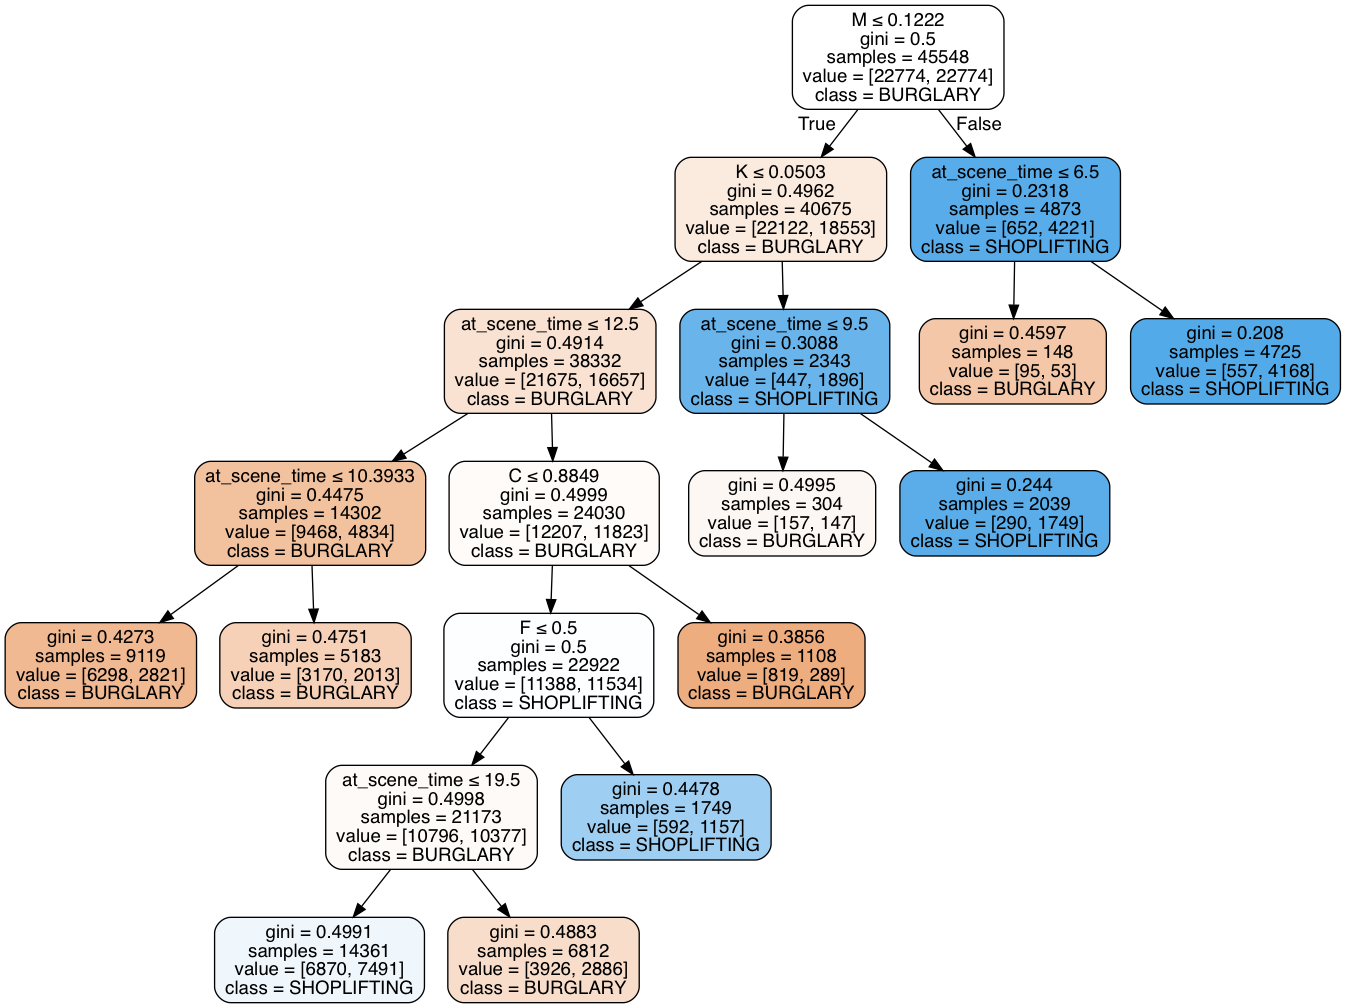

In [91]:
# generating the tree plot based on Decision Tree Classifier
import pydotplus 
from IPython.display import Image

feature_names = binary_data.columns
class_names = ['BURGLARY', 'SHOPLIFTING']

dot_data = tree.export_graphviz(tree_clf, out_file=None, 
                         feature_names=feature_names,
                         class_names=class_names,
                         filled=True, rounded=True,  
                         special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_pdf("data.pdf")
Image(graph.create_png())

#### Compare the accuracy score of the classifiers

In [92]:
from sklearn import metrics

### Generate predictions with base (non-boosted) classifier. ###

score = metrics.accuracy_score(y_test, tree_clf.predict(X_test))
print ('Base Classifier Accuracy = %s' % (score))
print

### Generate predictions with AdaBoost classifier. ###

score = metrics.accuracy_score(y_test, ab_clf.predict(X_test))
print ('AdaBoost Accuracy = %s' % (score))
print

### Generate predictions with LogitBoost classifier. ###

score = metrics.accuracy_score(y_test, lb_clf.predict(X_test))
print ('LogitBoost Accuracy = %s' % (score))
print

### Generate predictions with ExtraTrees classifier. ###

score = metrics.accuracy_score(y_test, extra_clf.predict(X_test))
print ('ExtraTrees Accuracy = %s' % (score))

### Generate predictions with RandomForest classifier. ###

score = metrics.accuracy_score(y_test, random_clf.predict(X_test))
print ('RandomForest Accuracy = %s' % (score))

Base Classifier Accuracy = 0.637822465976
AdaBoost Accuracy = 0.669104204753
LogitBoost Accuracy = 0.592931139549
ExtraTrees Accuracy = 0.696018687792
RandomForest Accuracy = 0.693378021532


#### Confusion matrix

In [93]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [94]:
def generate_confusion_matrix(clf, title):
    # Compute confusion matrix
    cnf_matrix = metrics.confusion_matrix(y_test, clf.predict(X_test))

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix for ' + title)

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix ' + title)

    plt.show()

Confusion matrix, without normalization
[[4420 2473]
 [1093 1860]]
Normalized confusion matrix
[[ 0.64123023  0.35876977]
 [ 0.37013207  0.62986793]]


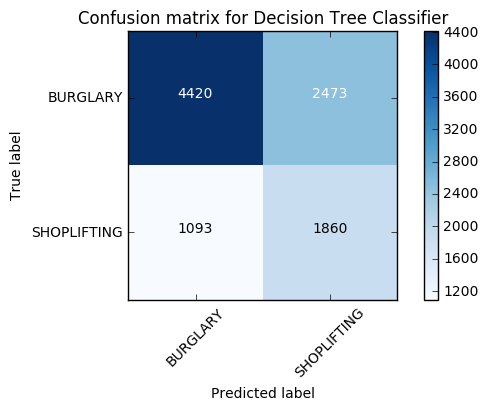

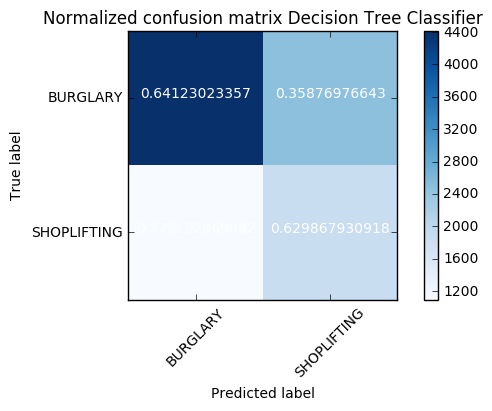

Confusion matrix, without normalization
[[4855 2038]
 [1220 1733]]
Normalized confusion matrix
[[ 0.70433773  0.29566227]
 [ 0.41313918  0.58686082]]


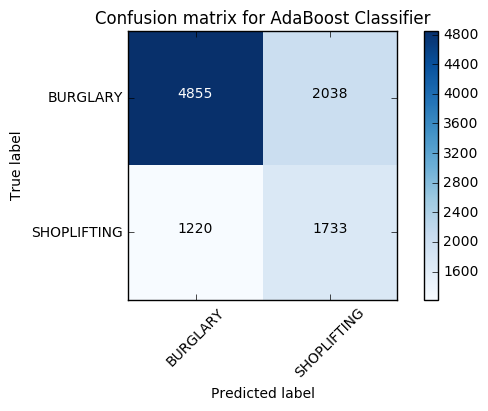

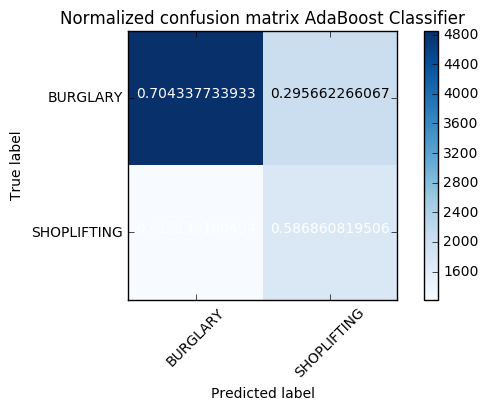

Confusion matrix, without normalization
[[3752 3141]
 [ 867 2086]]
Normalized confusion matrix
[[ 0.54432032  0.45567968]
 [ 0.29359973  0.70640027]]


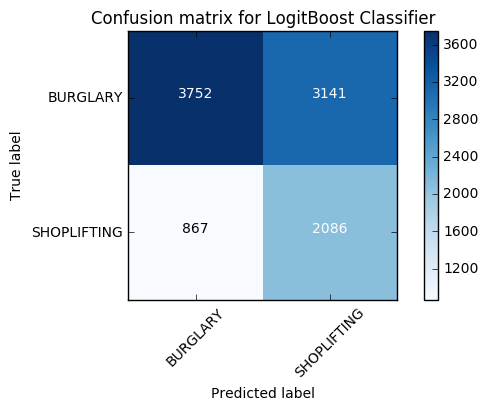

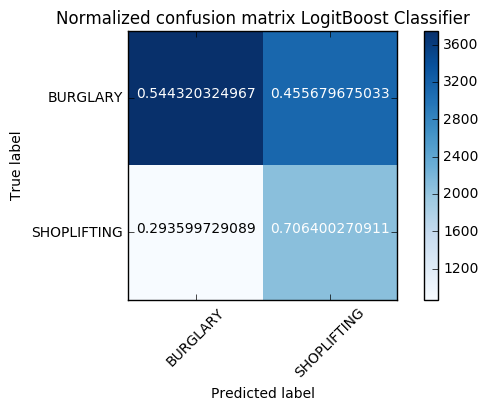

Confusion matrix, without normalization
[[5095 1798]
 [1195 1758]]
Normalized confusion matrix
[[ 0.73915567  0.26084433]
 [ 0.40467321  0.59532679]]


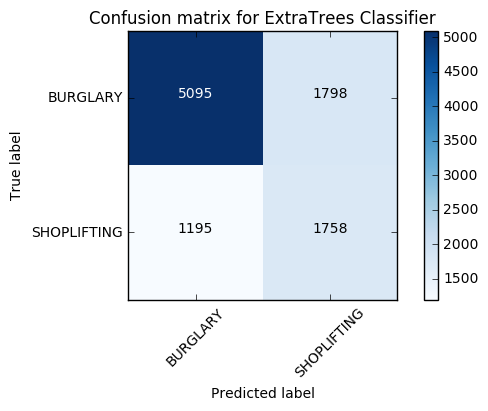

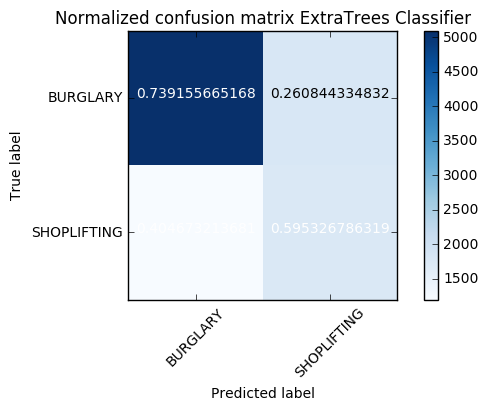

Confusion matrix, without normalization
[[5062 1831]
 [1188 1765]]
Normalized confusion matrix
[[ 0.7343682   0.2656318 ]
 [ 0.40230274  0.59769726]]


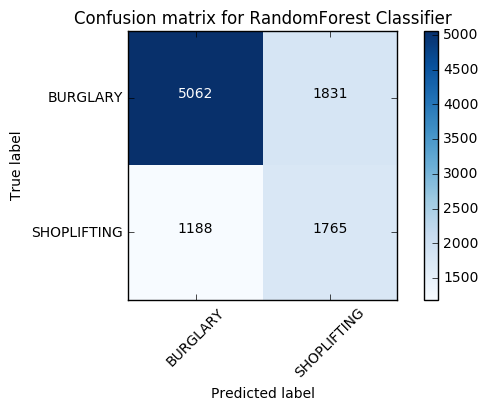

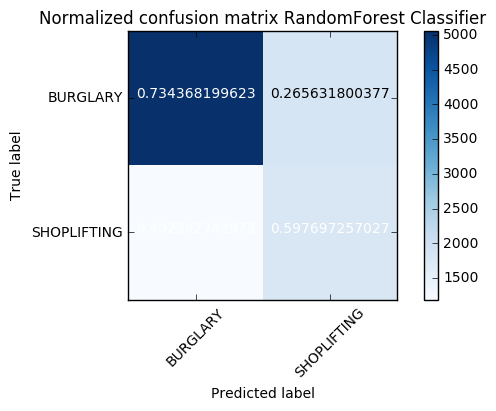

In [95]:
generate_confusion_matrix(tree_clf, 'Decision Tree Classifier')
generate_confusion_matrix(ab_clf, 'AdaBoost Classifier')
generate_confusion_matrix(lb_clf, 'LogitBoost Classifier')
generate_confusion_matrix(extra_clf, 'ExtraTrees Classifier')
generate_confusion_matrix(random_clf, 'RandomForest Classifier')